# Edge Detection & Color Spaces


---
## Install & Import Modules

In [ ]:
%%capture
# %%capture is used to ignore output when content is boring.
# This is how you install modules from jupyter notebook instead of terminal. 
!pip3 install opencv-contrib-python      #It contains opencv module from https://www.pyimagesearch.com/2018/09/19/pip-install-opencv/

In [2]:
# import the necessary packages
import numpy as np
import cv2
import os
import glob
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
cv2.__version__    # Make sure version above 3.4.3 

'4.1.0'

## Read Test Images


 Location  : test_images/test2.jpg 
 Dimensions: (720, 1280, 3)


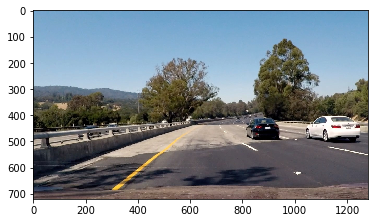

In [3]:
test_images_paths = glob.glob(os.path.join("test_images","*.jpg"))
                              
# Read image
image = mpimg.imread(test_images_paths[7])

# Display
print('\n Location  :', test_images_paths[0], '\n Dimensions:', image.shape)
plt.imshow(image)

## Threshold Function

In [4]:
def applyThresh(image, threshold):
    """
    Apply threshold to binary image. Setting to '1' pixels> minThresh & pixels <= maxThresh.
    """
    binary = np.zeros_like(image)
    binary[(image > threshold[0]) & (image <= threshold[1])] = 1
    return binary

## GrayScale Space

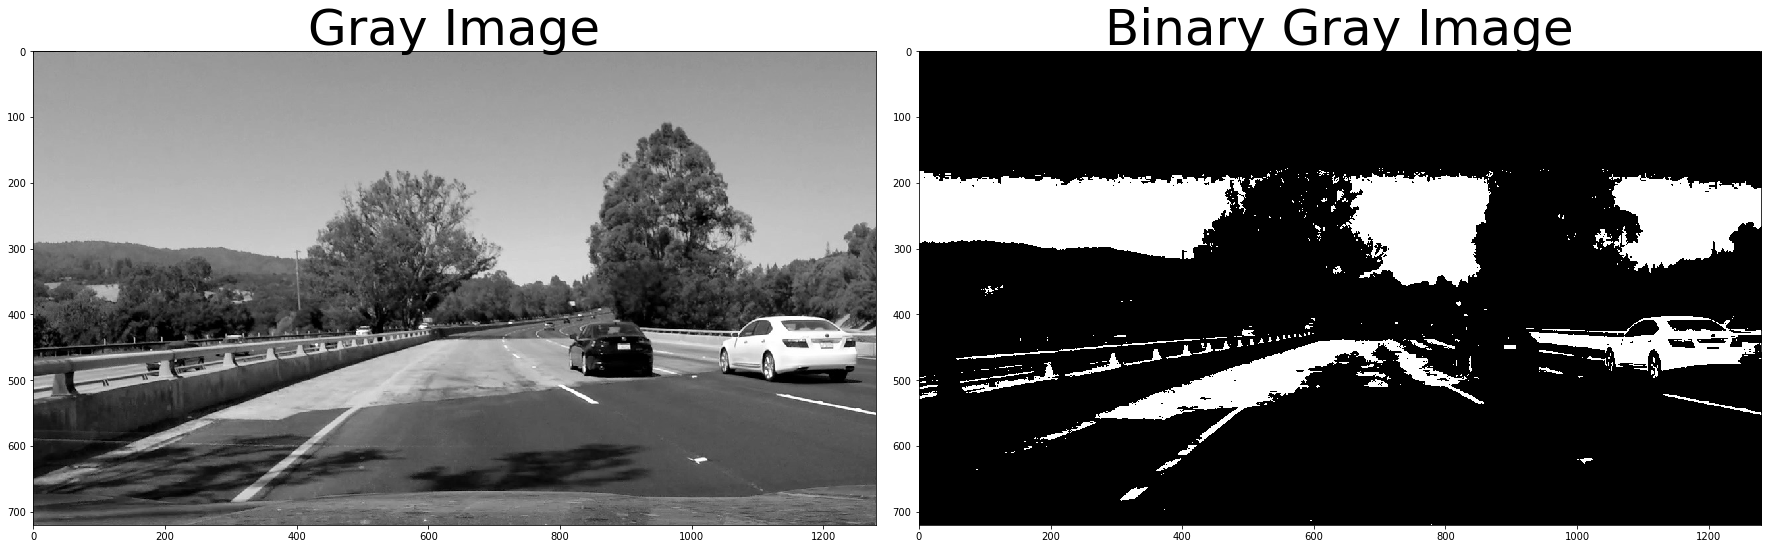

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
thresh = (180, 255)
bin_gray = applyThresh(gray, thresh)

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax1.imshow(gray, cmap='gray')
ax1.set_title('Gray Image', fontsize=50)
ax2.imshow(bin_gray, cmap="gray")
ax2.set_title('Binary Gray Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## RGB Space

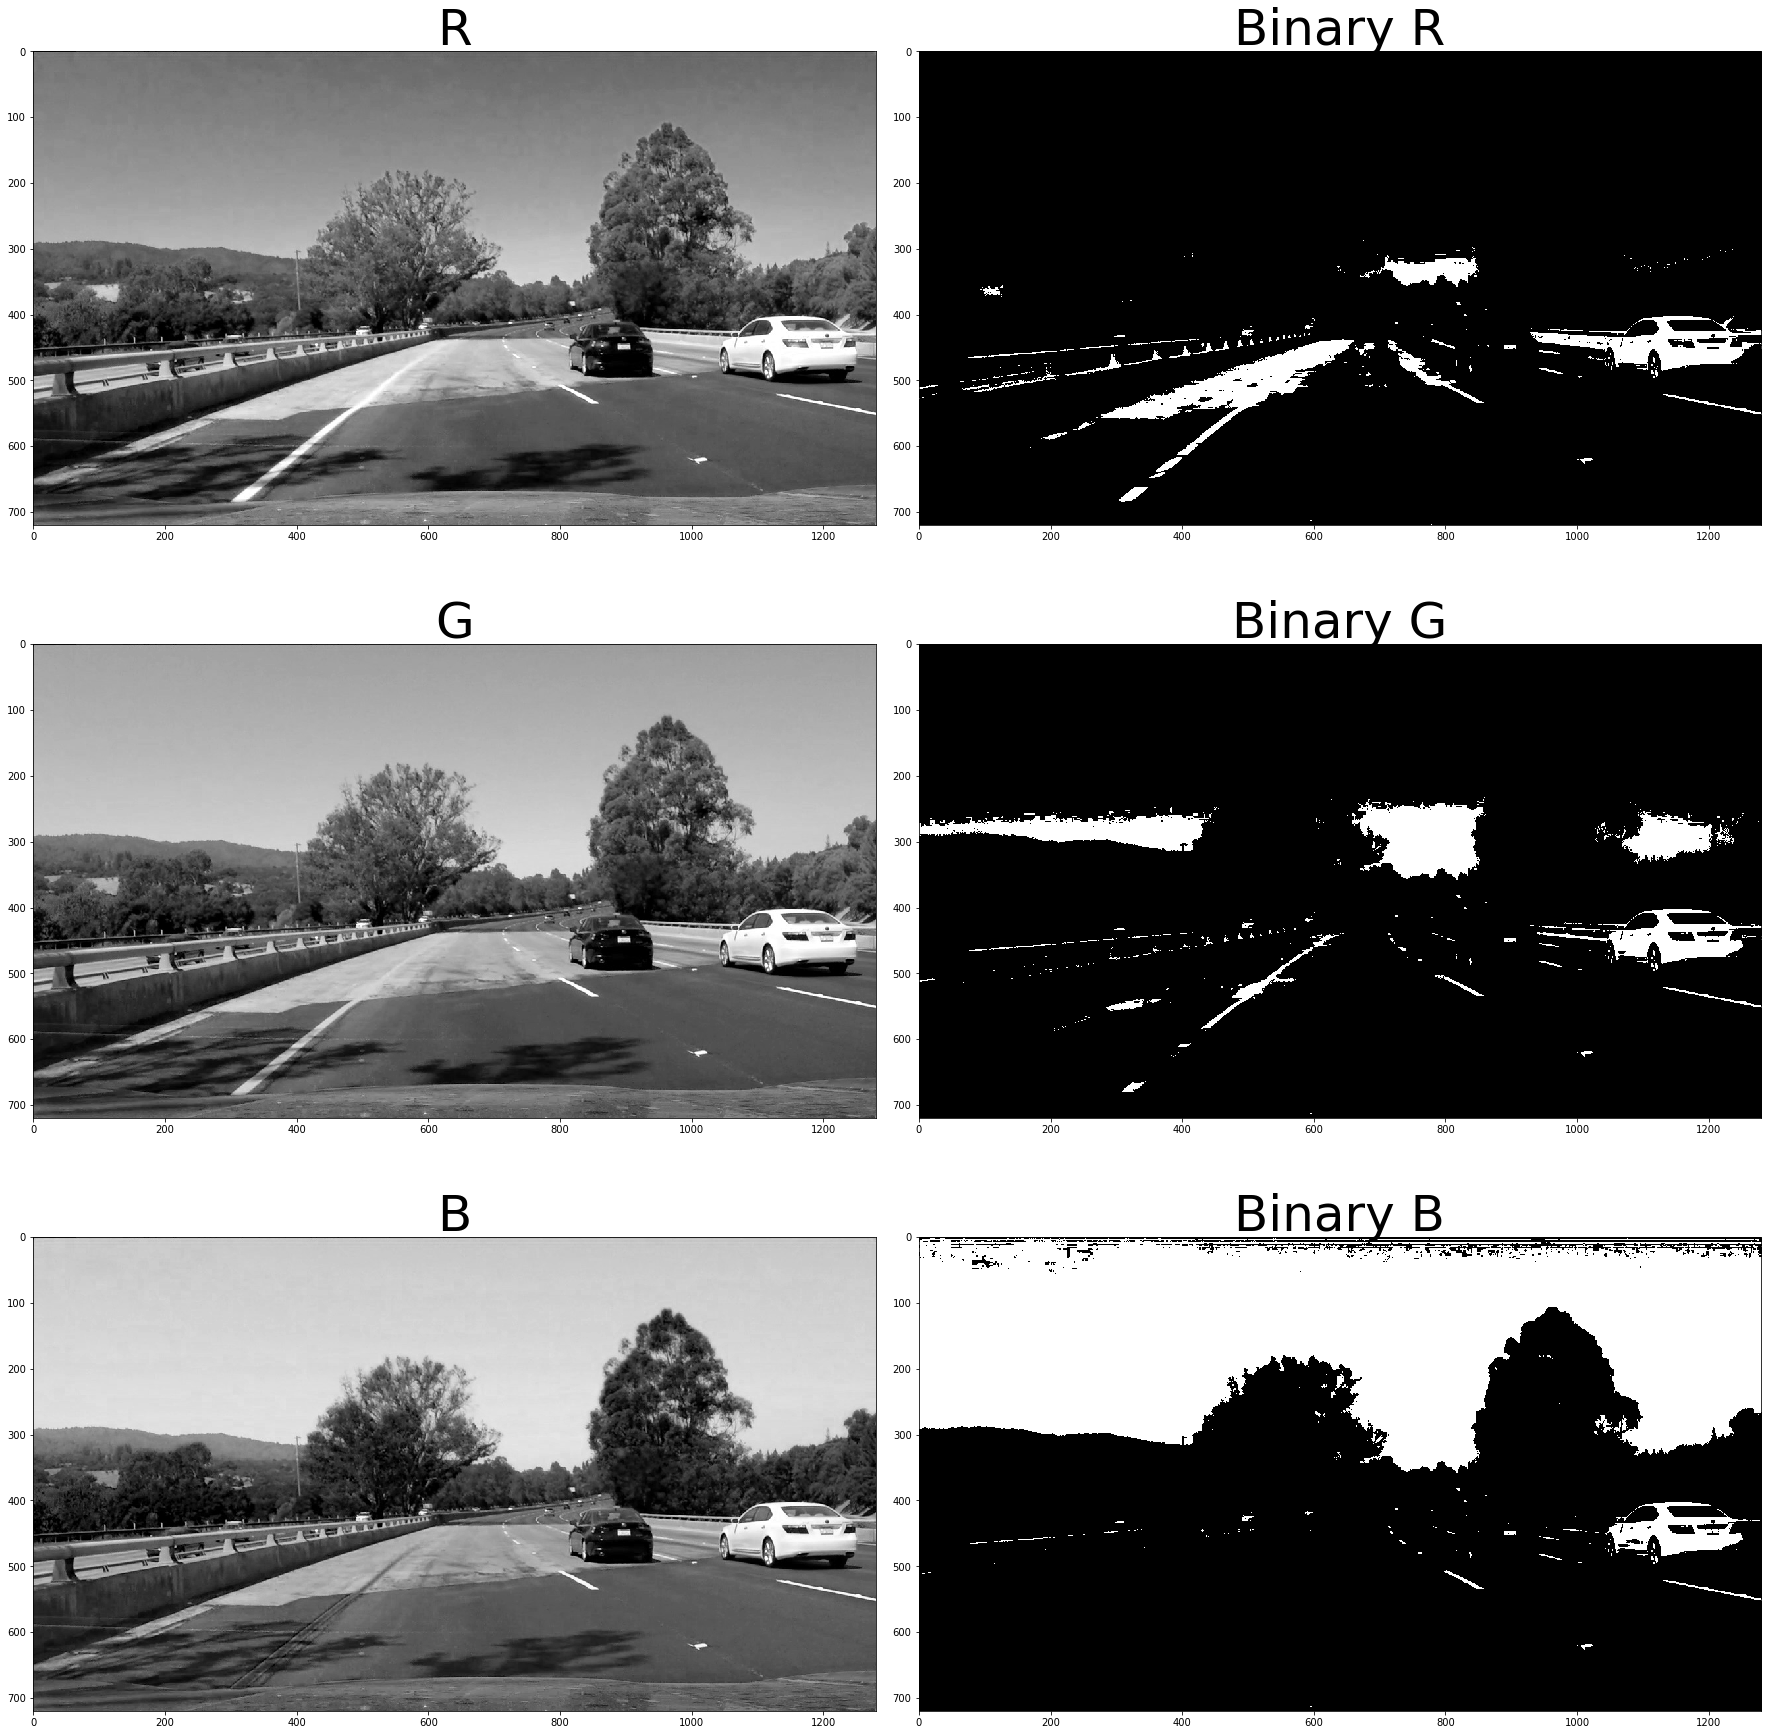

In [7]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

thresh = (200, 255)
bin_R = applyThresh(R, thresh)
bin_G = applyThresh(G, thresh)
bin_B = applyThresh(B, thresh)

# Display
f, ax = plt.subplots(3, 2, figsize=(24, 27))  # width and heights in inches
f.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
image_names  =[R,bin_R,G,bin_G,B,bin_B]
image_labels =['R','Binary R','G','Binary G','B','Binary B']
ax = ax.flatten()
for i in range(len(image_names)):
    ax[i].imshow(image_names[i], cmap='gray')
    ax[i].set_title(image_labels[i], fontsize=50)

## HLS Space

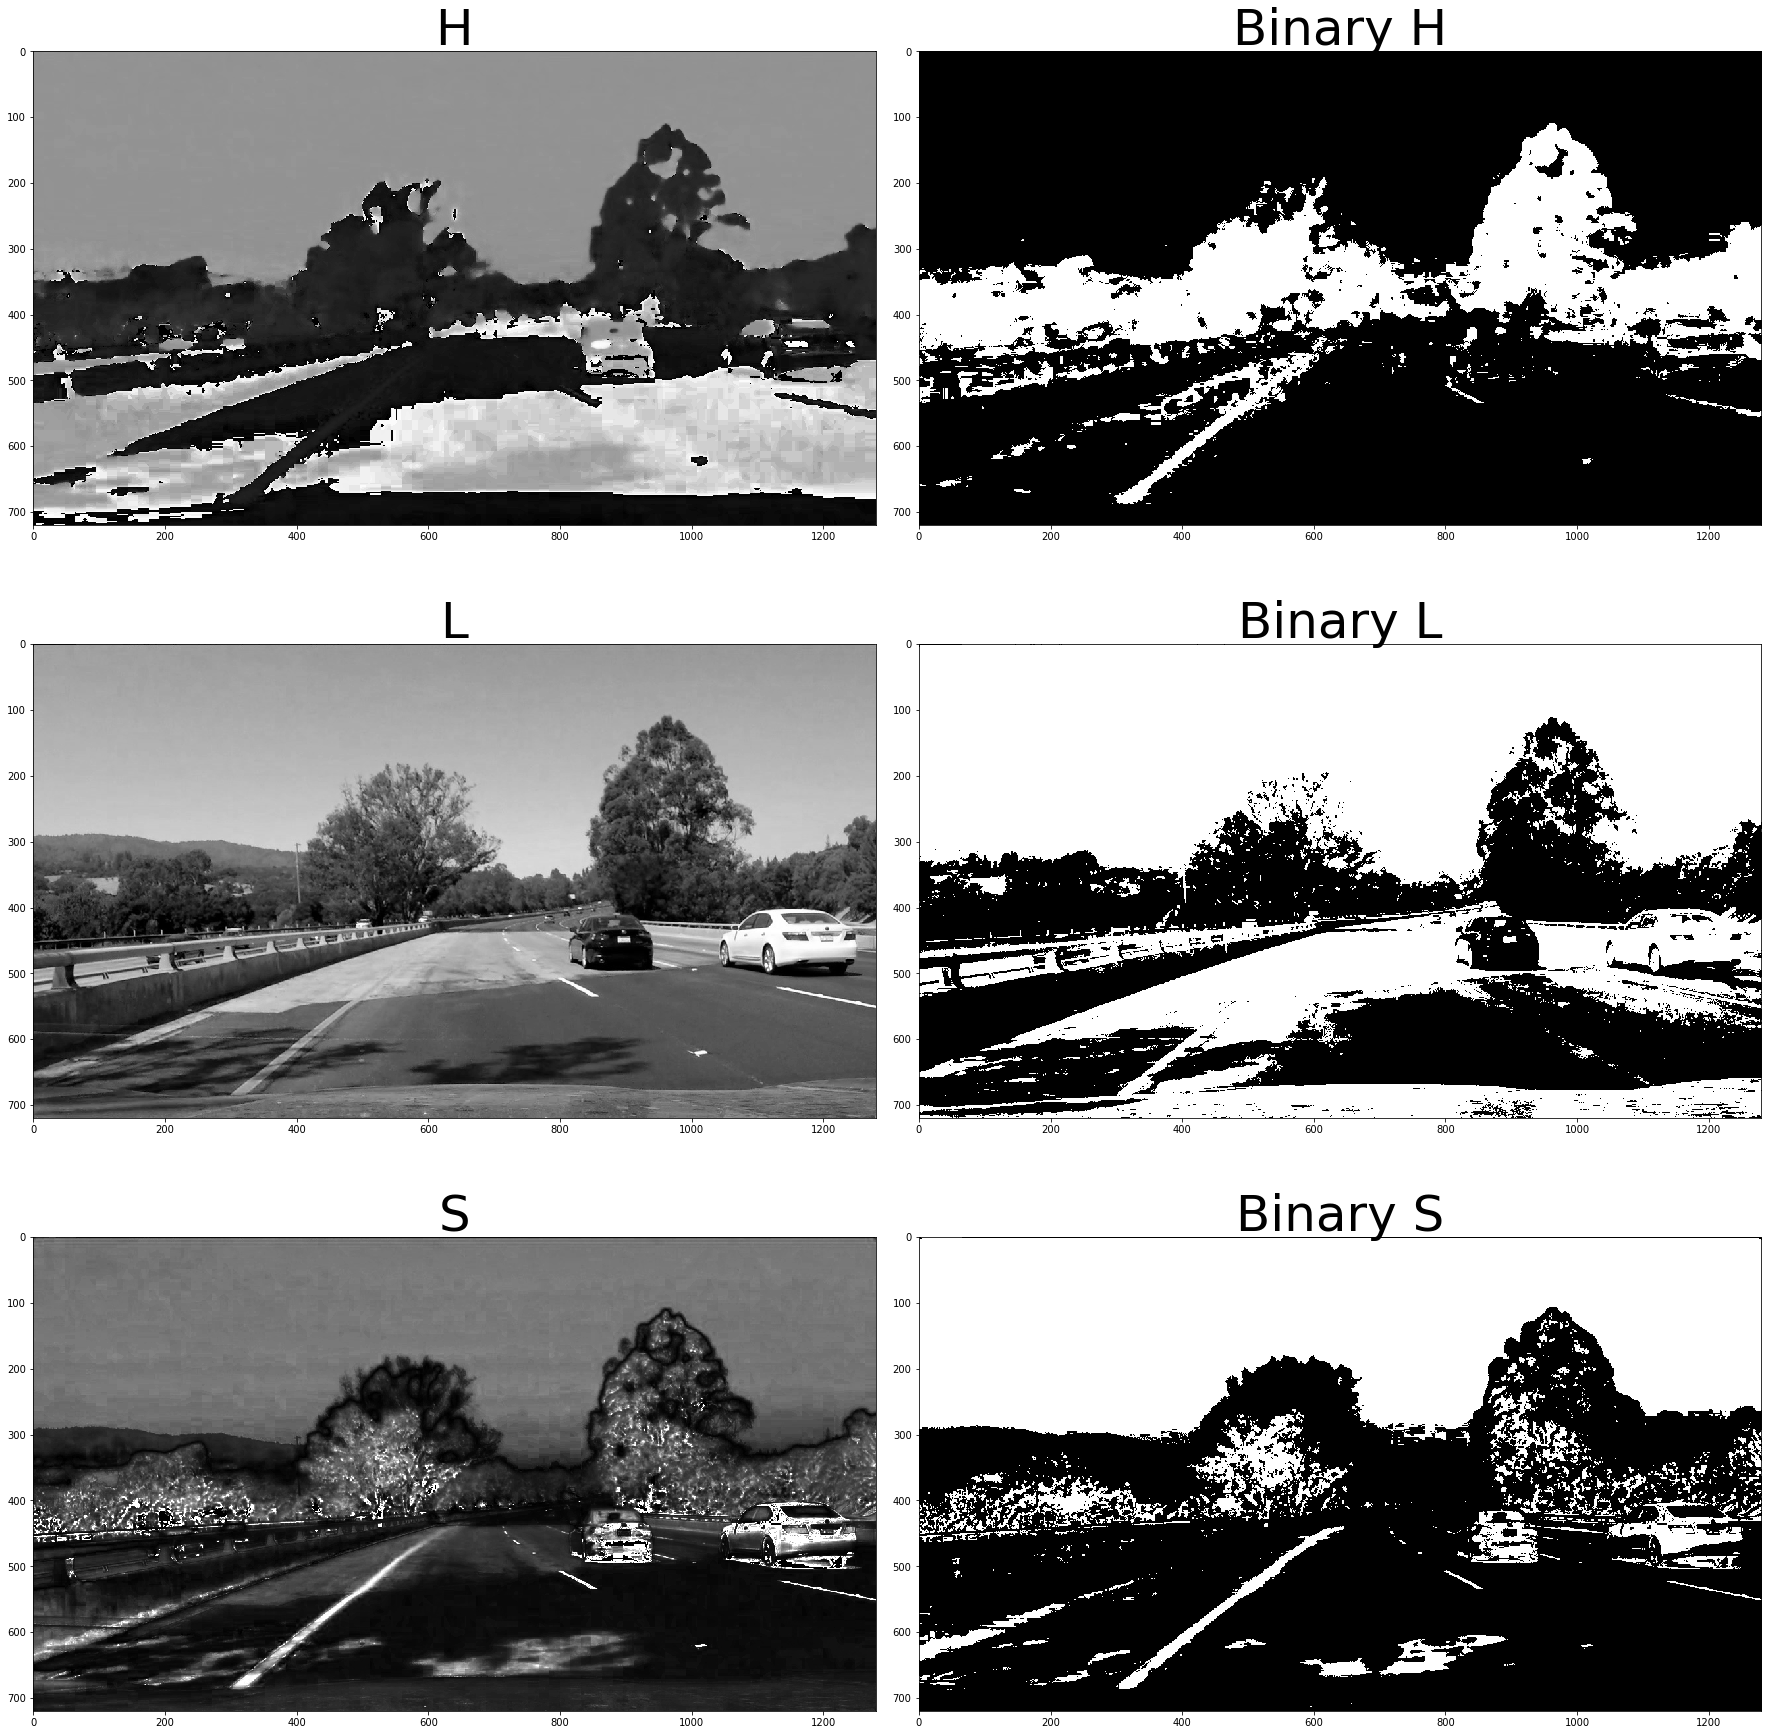

In [8]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (15, 100)
bin_H = applyThresh(H, thresh)
thresh = (90, 255)
bin_L = applyThresh(L, thresh)
bin_S = applyThresh(S, thresh)

# Display
f, ax = plt.subplots(3, 2, figsize=(24, 27))  # width and heights in inches
f.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
image_names  =[H,bin_H,L,bin_L,S,bin_S]
image_labels =['H','Binary H','L','Binary L','S','Binary S']
ax = ax.flatten()
for i in range(len(image_names)):
    ax[i].imshow(image_names[i], cmap='gray')
    ax[i].set_title(image_labels[i], fontsize=50)

## Sobel

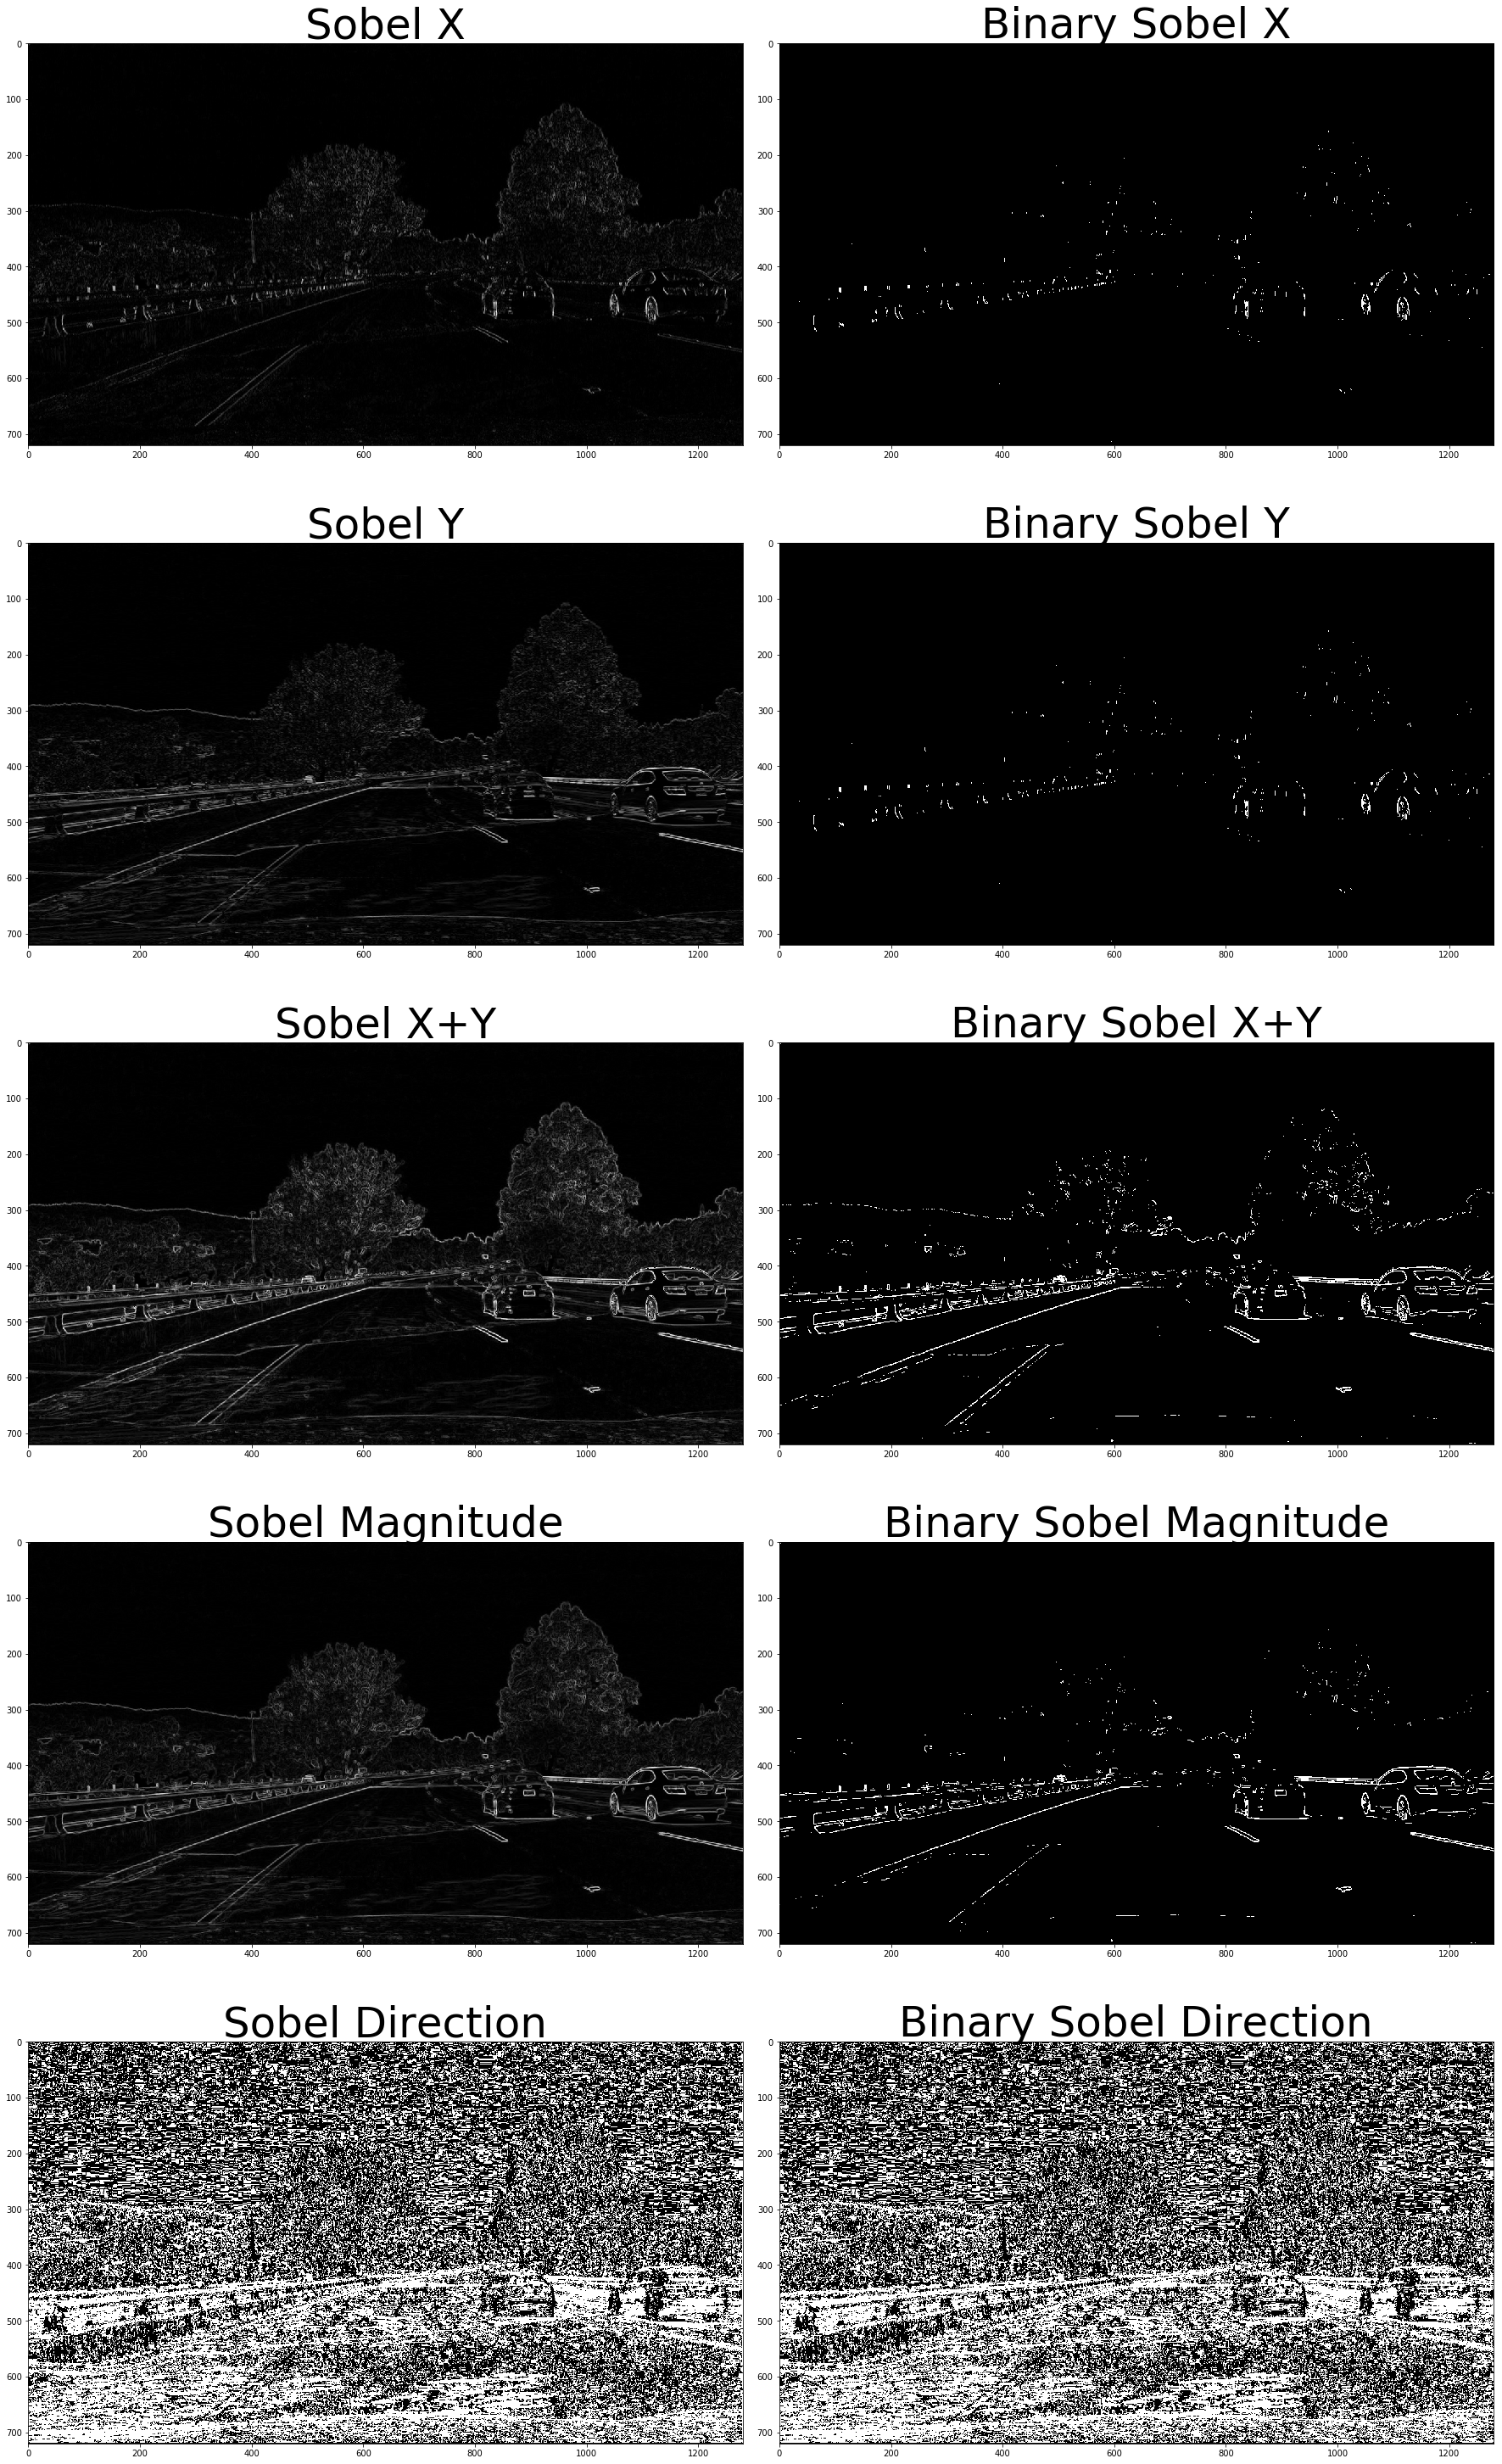

In [18]:
# Sobel X
abs_sobelx = np.abs(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3))
sobelx     = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Sobel Y
abs_sobely = np.abs(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3))
sobely     = np.uint8(255*abs_sobely/np.max(abs_sobely))

# Sobel X + Y
sobel_xy = sobelx + sobely
#sobel_xy = np.uint8(255*sobel_xy/np.max(sobel_xy))

# Sobel Magnitude
sobel_mag = np.sqrt(abs_sobelx**2 +abs_sobely**2)
sobel_mag = np.uint8(255*sobel_mag/np.max(sobel_mag))

# Sobel Direction
sobel_dir = np.uint8(np.arctan2(abs_sobely, abs_sobelx))

thresh = (90, 255)
bin_sobelx    = applyThresh(sobelx, thresh)
bin_sobely    = applyThresh(sobely, thresh)
bin_sobel_xy  = applyThresh(sobel_xy, thresh)
bin_sobel_mag = applyThresh(sobel_mag, thresh)
thresh=(0.7, int(np.pi/2))
bin_sobel_dir = applyThresh(sobel_dir, thresh)

# Display
f, ax = plt.subplots(5, 2, figsize=(24, 9*5))  # width and heights in inches
f.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
image_names  =[sobelx    , bin_sobelx,
               sobely    , bin_sobelx,
               sobel_xy  , bin_sobel_xy,
               sobel_mag , bin_sobel_mag,
               sobel_dir , bin_sobel_dir,]
image_labels =['Sobel X','Binary Sobel X','Sobel Y','Binary Sobel Y','Sobel X+Y','Binary Sobel X+Y','Sobel Magnitude', 'Binary Sobel Magnitude','Sobel Direction', 'Binary Sobel Direction']
ax = ax.flatten()
for i in range(len(image_names)):
    ax[i].imshow(image_names[i], cmap='gray')
    ax[i].set_title(image_labels[i], fontsize=50)

## HED: Hollistically-Nested Edge Detection
Is a supervised deep neural network for edge detection.  For this we will need the model and the trained weights of the model which are found in the `hed_model` folder. An implementation through caffe and GPU can be seen [here](https://github.com/s9xie/hed/blob/master/examples/hed/HED-tutorial.ipynb), but for simplicity we will use OpenCV's `dnn` library. 

[INFO] loading edge detector...
[INFO] performing holistically-nested edge detection...


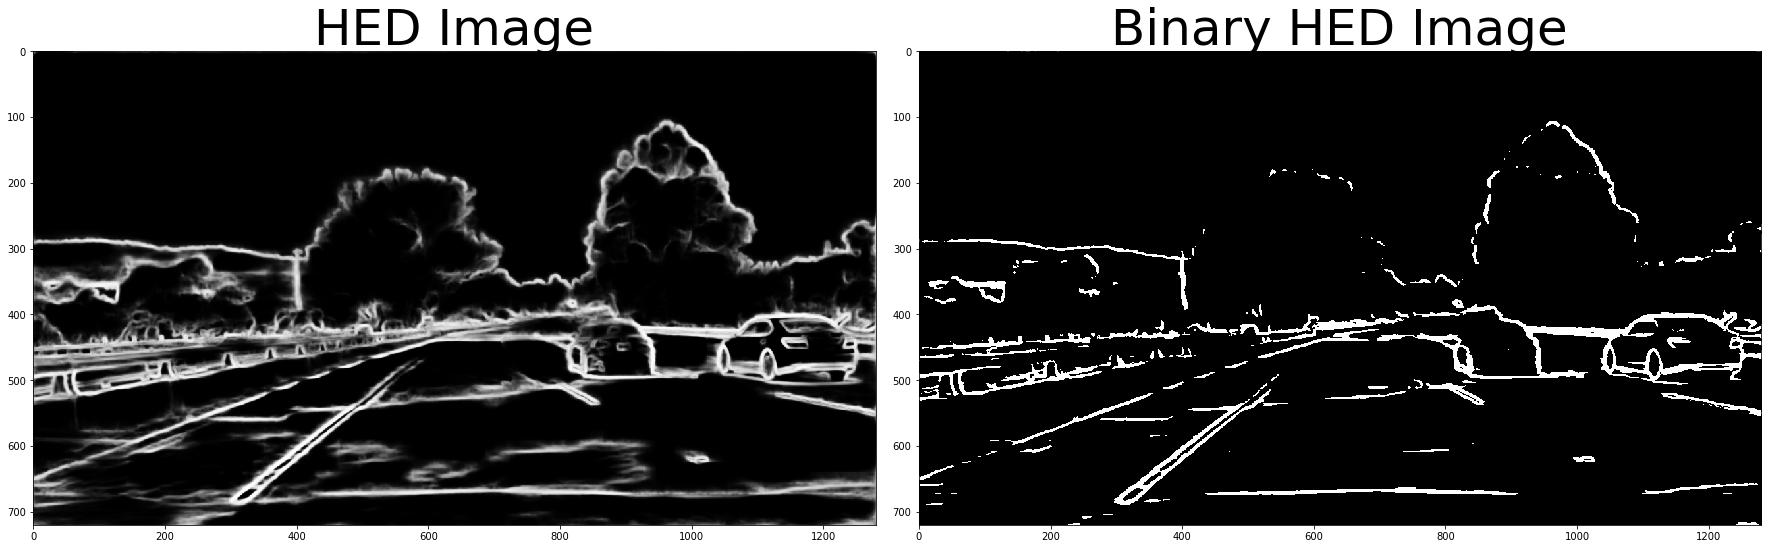

In [5]:
# Create new Layer to add to current net
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

# load model
print("[INFO] loading edge detector...")
protoPath = os.path.join("hed_model","deploy.prototxt")
modelPath = os.path.join("hed_model","hed_pretrained_bsds.caffemodel")
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our new layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

# Preprocess image
(height, width) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(width, height),
                            mean=(104.00698793, 116.66876762, 122.67891434),
                            swapRB=False, crop=False)

# Run Model: Perform a forward pass of blob image
print("[INFO] performing holistically-nested edge detection...")
net.setInput(blob)
hed = net.forward()
hed = cv2.resize(hed[0, 0], (width, height))
hed = (255 * hed).astype("uint8")

# Apply Threshold
thresh = (180, 255)
bin_hed = applyThresh(hed, thresh)

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax1.imshow(hed, cmap='gray')
ax1.set_title('HED Image', fontsize=50)
ax2.imshow(bin_hed, cmap="gray")
ax2.set_title('Binary HED Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining Techniques

In [ ]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

## Bibliography

- [Laplacian, Sobel, Scharr](https://docs.opencv.org/3.3.0/d5/d0f/tutorial_py_gradients.html)
- [Canny](https://docs.opencv.org/3.3.0/da/d22/tutorial_py_canny.html), [Auto Canny](https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/)
- [Gaussian, Bilateral](https://docs.opencv.org/3.3.0/d4/d13/tutorial_py_filtering.html)
- [HED: Hollistically-Nested Edge Detection](https://www.pyimagesearch.com/2019/03/04/holistically-nested-edge-detection-with-opencv-and-deep-learning/), [Official Repo](https://github.com/s9xie/hed), 

There are many other edge detectors: Roberts, Prewitt, Laplacian of Gaussian, etc which are not implemented by default in openCV. Nonetheless, everything listed above and in bullets can be implemented by using `cv2.filter2D` and defining a `kernel`. This is a code [example](https://gist.github.com/rahit/c078cabc0a48f2570028bff397a9e154) by another github user and this is the [theory](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.301.927&rep=rep1&type=pdf)


In [ ]:
# Load video
cap = cv2.VideoCapture(input_video_path)

# Read frame
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_num = 300#random.randint(0,frame_count)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Get Edges through different techniques
frame     = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
gray      = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
blur_gray = cv2.bilateralFilter(gray,9,75,75)
laplacian = cv2.Laplacian(blur_gray,cv2.CV_64F)
sobelx    = np.uint8(np.abs(cv2.Sobel(blur_gray,cv2.CV_64F,1,0,ksize=3)))
sobely    = np.uint8(np.abs(cv2.Sobel(blur_gray,cv2.CV_64F,0,1,ksize=3)))
sobel     = sobelx + sobely
scharrx   = np.uint8(np.abs(cv2.Scharr(blur_gray,cv2.CV_64F,1,0)))
scharry   = np.uint8(np.abs(cv2.Scharr(blur_gray,cv2.CV_64F,0,1)))
scharr    = scharrx + scharry
canny     = cv2.Canny(blur_gray, 60, 80)

# Display all our options 
image_names  =[frame,laplacian,sobelx,sobely,sobel,scharrx,scharry,scharr,canny]
image_labels =['Original','Laplacian','Sobel X','Sobel Y', 'Sobel','Scharr X','Scharr Y','Scharr','Canny']
n_img = len(image_labels)             # Total number of images
plt.figure(1,figsize=(13, 8*n_img))   # inches width and height
for i in range(n_img):
    plt.subplot(n_img, 1, i+1)
    plt.imshow(image_names[i],cmap = 'gray'), plt.title(image_labels[i]), plt.xticks([]), plt.yticks([])
    # Note: 'plt.imshow' normalizes values internally from 0-1 automatically


Now that we are over with the exploration, lets create an image processing pipeline that will be implemented to the intervals chosen.

In [ ]:
def pipeline(image):
    """"
    Performs image processing to 'turn off the lights' on an image. 
    It assumes a BGR input image and returns a binary image.
    """
    gray      = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur_gray = cv2.bilateralFilter(gray,9,75,75)
    laplacian = cv2.Laplacian(blur_gray,cv2.CV_64F)
    sobelx    = np.uint8(np.abs(cv2.Sobel(blur_gray,cv2.CV_64F,1,0,ksize=3)))
    sobely    = np.uint8(np.abs(cv2.Sobel(blur_gray,cv2.CV_64F,0,1,ksize=3)))
    sobel     = sobelx + sobely
    
    sobel_norm = 255*(sobel - np.min(sobel))/(np.max(sobel)-np.min(sobel))    
    
    return sobel_norm

Let's make our video! Just run the cell below. Set the intervals acording to your video. This is useful [guide](https://zulko.github.io/moviepy/getting_started/compositing.html) to concatenate clips.

In [ ]:
# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")
    
# Turn off the lights in video [93,184] , [465,1458], and [1588,1662]
clip  = VideoFileClip(input_video_path)
clip_0_92 = clip.fl_image()
clip_93_184 = clip.fl_image(pipeline)
video_clip3 = clip.fl_image(pipeline)
clip = VideoFileClip(video_path).subclip(0,5)    # .subclip(start_second,end_second)

# Save rotated video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_rotated." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()

def browse_images(digits):
    n = len(digits.images)
    def view_image(i):
        plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Training: %s' % digits.target[i])
        plt.show()
    ipw.interact(view_image, i=(0,n-1))

browse_images(digits)

In [ ]:

cap = cv2.VideoCapture(input_video_path)
# cap.set(cv2.CAP_PROP_POS_FRAMES, 1009)
# _,frame=cap.read()
# frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
# plt.imshow(frame)
# plt.show()

def browse_images(cap):
    n = frame_count#int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    def view_image(i):
        
        cap = cv2.VideoCapture(input_video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        _,frame=cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.show()
    ipw.interact(view_image, i=(0,n-1))

browse_images(cap)

In [ ]:
# Youtube Video explaining about widgets
#display (YouTubeVideo('eWzY2nGfkXk'))

# Widgets
right_btn  = ipw.Button( button_style='info', icon='fa-arrow-right' )
left_btn   = ipw.Button( button_style='info', icon='fa-arrow-left') # 'fa-step-forward'
slider     = ipw.IntSlider(value=0, min=0, max=frame_count-1, description='FRAME:', continuous_update=True)
title      = ipw.HTML("<h3 class='text-left'><font color='green'> My Media Player</font> in <font color='blue'> Frames</font></h3>")
play       = ipw.Play(interval=10, min=0, max=frame_count-1, description="Press play")
video_out  = ipw.Output(layout={'border': '1px solid black'})
#print(video_out.keys) # Check all input arguments

# Linkers
play_slider_link = ipw.jslink((play, 'value'), (slider, 'value'))


# out.append_stdout('Output appended with append_stdout')
# out.append_display_data(YouTubeVideo('eWzY2nGfkXk'))
#     |

#Callback functions
plt.figure(figsize=(20, 20))   #width, height in inches
def right_btn_callback(change):
    slider.value = min(slider.value+1,slider.max)
def left_btn_callback(change):
    slider.value = max(slider.value-1,slider.min)
def play_callback(change):
    slider.value = play.value
def slider_callback(change):
    video_out.clear_output()
    cap.set(cv2.CAP_PROP_POS_FRAMES, slider.value)
    _,frame=cap.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    with video_out:
        plt.xticks([])
        plt.yticks([])
        plt.imshow(frame)
        display(plt.show())
#     with video_out:
#         display(plt.imshow(frame))
#     video_out.append_display_data(frame)

# Triggers        
right_btn.on_click(right_btn_callback)
left_btn.on_click(left_btn_callback)
slider.observe(slider_callback, 'value')
play.observe(play_callback, 'value')

#Display
media_player = ipw.VBox([title, video_out, ipw.HBox([play, left_btn, slider, right_btn])])
display(media_player)


Use this to discover what frame numbers we need to set the beginnings and ends of when we turn OFF the lights in the video.

- [Widget List](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#Button)
- [Widget_Tutorial](https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916)

In [ ]:
def DisplayFrame():
    # Read frame
    _,frame=cap.read(0)
    
    # Display
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(11, 5))   #width, height in inches
    plt.title("Original")
    plt.imshow(frame)

right.on_click(DisplayFrame)

<b> Play the video inline by running the following cell, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.
</b>

In [ ]:
# When everything done, release the capture
cap.release()